# Improving energy estimation of a Fermionic Hamiltonian with SQD

In this tutorial we implement a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) showing how to post-process noisy quantum samples to find an approximation to the ground state of the $N_2$ molecule at equilibrium in the 6-31G basis set. We will follow a sample-based quantum diagonalization approach [[1]](https://arxiv.org/abs/2405.05068) to process samples taken from a ``36``-qubit quantum circuit. In order to account for the effect of quantum noise, the configuration recovery technique is used.

The pattern can be described in four steps:

1. **Step 1: Map to quantum problem**
    - Generate an ansatz for estimating the ground state
2. **Step 2: Optimize the problem**
    - Transpile the ansatz for the backend
3. **Step 3: Execute experiments**
    - Draw samples from the ansatz using the ``Sampler`` primitive
4. **Step 4: Post-process results**
   - Self-consistent configuration recovery loop
       - Post-process the full set of bitstring samples, using prior knowledge of particle number and the average orbital occupancy calculated on the most recent iteration.
       - Probabilistically create batches of subsamples from recovered bitstrings.
       - Project and diagonalize the molecular Hamiltonian over each sampled subspace.
       - Save the minimum ground state energy found across all batches and update the avg orbital occupancy.


For this example, the interacting-electron Hamiltonian takes the generic form:

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ 
\sum_{ \substack{prqs\\\sigma\tau} }
\frac{(pr|qs)}{2} \, 
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma}
$$

$\hat{a}^\dagger_{p\sigma}$/$\hat{a}_{p\sigma}$ are the fermionic creation/annihalation operators associated to the $p$-th basis set element and the spin $\sigma$. $h_{pr}$ and $(pr|qs)$ are the one- and two-body electronic integrals.

The SQD workflow with  self-consistent configuration recovery is depicted in the following diagram.

![SQD diagram](../_static/images/sqd_diagram.png)

SQD is known to work well when the target eigenstate is sparse: the wave function is supported in a set of basis states $\mathcal{S} = \{|x\rangle \}$ whose size does not increase exponentially with the size of the problem. In this scenario, the diagonalization of the Hamiltonian projected into the subspace defined by $\mathcal{S}$:
$$
H_\mathcal{S} = P_\mathcal{S} H  P_\mathcal{S} \textrm{ with } P_\mathcal{S} = \sum_{x \in \mathcal{S}} |x \rangle \langle x |;
$$
yields a good approximation to the target eigenstate. The role of the quantum device is to produce samples of the members of $\mathcal{S}$ only. First, a quantum circuit prepares the state $|\Psi\rangle$ in the quantum device. The Jordan-Wigner encoding is used. Consequently, members of the computational basis represent Fock states (electronic configurations/determinants). The circuit is sampled in the computational basis, yielding the set of noisy configurations $\tilde{\mathcal{X}}$. The configurations are represented by bitstrings. The set $\tilde{\mathcal{X}}$ is then passed into the classical post-processing block, where the [self-consistent configuration recovery technique](https://arxiv.org/abs/2405.05068) is used. In the SQD framework, the role of the quantum device is to produce a probability distribution.

### Step 1: Map problem to a quantum circuit

In this tutorial, we will approximate the ground state energy of an $N_2$ molecule. First, we will specify the molecule and its properties. Next, we will create a [local unitary cluster Jastrow (LUCJ)](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) ansatz (quantum circuit) to generate samples from a quantum computer for ground state energy estimation.

First, we will specify the molecule and its properties.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570775
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


Next, we will create the ansatz. The ``LUCJ`` ansatz is a parameterized quantum circuit, and we will initialize it with `t2` and `t1` amplitudes obtained from a CCSD calculation.

In [2]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929734  E_corr = -0.2045891221988317


<class 'pyscf.cc.ccsd.CCSD'> does not have attributes  converged


We will use the [ffsim](https://github.com/qiskit-community/ffsim/tree/main) package to create and initialize the ansatz with `t2` and `t1` amplitudes computed above. Since our molecule has a closed-shell Hartree-Fock state, we will use the spin-balanced variant of the UCJ ansatz, [UCJOpSpinBalanced](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced).

As our target IBM hardware has a heavy-hex topology, we will adopt the _zig-zag_ pattern used in [[2]](https://pubs.rsc.org/en/content/articlehtml/2023/sc/d3sc02516k) for qubit interactions. In this pattern, orbitals (represented by qubits) with the same spin are connected with a line topology (red and blue circles) where each line take a zig-zag shape due the heavy-hex connectivity of the target hardware. Again, due to the heavy-hex topology, orbitals for different spins have connections between every 4th orbital (0, 4, 8, etc.) (purple circles).

![lucj_ansatz](../_static/images/lucj_ansatz_zig_zag_pattern.jpg)

In [3]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

### Step 2: Optimize the problem

Next, we will optimize our circuit for a target hardware. We need to choose the hardware device to use before optimizing our circuit. We will use a fake 127-qubit backend from ``qiskit_ibm_runtime`` to emulate a real device.

In [4]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

Next, we recommend the following steps to optimize the ansatz and make it hardware-compatible.

- Select physical qubits (`initial_layout`) from the target hardware that adheres to the zig-zag pattern described above. Laying out qubits in this pattern leads to an efficient hardware-compatible circuit with less gates.
- Generate a staged pass manager using the [generate_preset_pass_manager](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#generate_preset_pass_manager) function from qiskit with your choice of `backend` and `initial_layout`.
- Set the `pre_init` stage of your staged pass manager to `ffsim.qiskit.PRE_INIT`. `ffsim.qiskit.PRE_INIT` includes qiskit transpiler passes that decompose gates into orbital rotations and then merges the orbital rotations, resulting in fewer gates in the final circuit.
- Run the pass manager on your circuit. 

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'rz': 4531, 'sx': 3435, 'ecr': 1366, 'x': 224, 'measure': 32, 'barrier': 1})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 2455, 'sx': 2151, 'ecr': 730, 'x': 83, 'measure': 32, 'barrier': 1})


### Step 3: Execute experiments

After optimizing the circuit for hardware execution, we are ready to run it on the target hardware and collect samples for ground state energy estimation. As we only have one circuit, we will use Qiskit Runtime's [Job execution mode](https://docs.quantum.ibm.com/guides/execution-modes) and execute our circuit.

**Note: We have commented out the code for running the circuit on a QPU and left it for the user's reference. Instead of running on real hardware in this guide, we will just generate random samples drawn from the uniform distribution.**

In [6]:
import numpy as np

# from qiskit_ibm_runtime import SamplerV2 as Sampler
# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=10_000)
# primitive_result = job.result()
# pub_result = primitive_result[0]
# counts = pub_result.data.meas.get_counts()
from qiskit_addon_sqd.counts import generate_counts_uniform

rng = np.random.default_rng(24)
counts = generate_counts_uniform(10_000, num_orbitals * 2, rand_seed=rng)

### Step 4: Post-process results

First, we will transform the counts into a bitstring matrix and probability array for post-processing.

Each row in the matrix represents one unique bitstring. Since qubits are indexed from the right of a bitstring in Qiskit, column ``0`` represents qubit ``N-1``, and column ``N-1`` represents qubit ``0``, where ``N`` is the number of qubits.

The alpha particles are represented in the column index range ``(N, N/2]``, and the beta particles are represented in the column range ``(N/2, 0]``.

In [7]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

Next, we iteratively refine the samples using configuration recovery and approximate the ground state at each iteration

There are a few user-controlled options which are important for this technique:

- ``iterations``: Number of self-consistent configuration recovery iterations
- ``n_batches``: Number of batches of configurations used by the different calls to the eigenstate solver
- ``samples_per_batch``: Number of unique configurations to include in each batch
- ``max_davidson_cycles``: Maximum number of Davidson cycles run by each eigensolver

In [8]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import solve_fermion
from qiskit_addon_sqd.subsampling import postselect_and_subsample

# SQD options
iterations = 5

# Eigenstate solver options
n_batches = 10
samples_per_batch = 300
max_davidson_cycles = 200

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = []
avg_occupancy = None
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we begin with the full set of noisy configurations.
    if avg_occupancy is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            avg_occupancy,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )

    # Create batches of subsamples. We post-select here to remove configurations
    # with incorrect hamming weight during iteration 0, since no config recovery was performed.
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = []
    coeffs = []
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore,
            eri,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp.append(avg_occs)
        coeffs.append(coeffs_sci)

    # Combine batch results
    avg_occupancy = tuple(np.mean(occs_tmp, axis=0))

    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy)

Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


The first plot shows that after a couple of iterations we estimate the ground state energy within ``~40 mH`` (chemical accuracy is typically accepted to be ``1 kcal/mol`` $\approx$ ``1.6 mH``). Remember, the quantum samples in this demo were pure noise. The signal here comes from *a priori* knowledge of the electronic structure and molecular Hamiltonian.

The second plot shows the average occupancy of each spatial orbital after the final iteration. We can see that both the spin-up and spin-down electrons occupy the first five orbitals with high probability in our solutions.

Exact energy: -109.04667 Ha
SQD energy: -109.00660 Ha
Absolute error: 0.04007 Ha


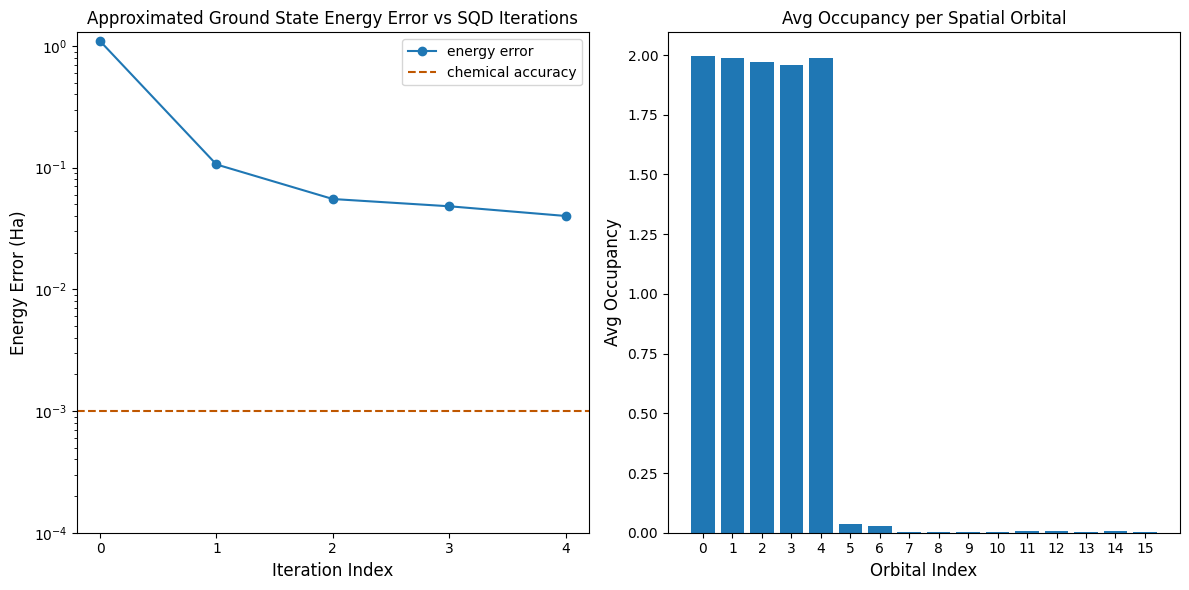

In [9]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(iterations)
min_e = [np.min(e) for e in e_hist]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = occupancy_hist[-1][0] + occupancy_hist[1][1]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.show()

### References

[1] Robledo-Moreno, Javier, et al. ["Chemistry beyond exact solutions on a quantum-centric supercomputer."](https://arxiv.org/abs/2405.05068) arXiv preprint arXiv:2405.05068 (2024).

[2] Motta, Mario, et al. ["Bridging physical intuition and hardware efficiency for correlated electronic states: the local unitary cluster Jastrow ansatz for electronic structure."](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) Chemical Science 14.40 (2023): 11213-11227.